# Introducing the Matched filter

* The matched filter is responsible for turning the received signal $R(t)$ into estimates of the transmitted symbols.

* The matched filter is 
  - a linear, time-invariant system with
  - impulse response $h_{MF}(t) = p(\Tau_0 - t)$, where $p(t)$ is the pulse shape used by the transmitter.
    + the important aspect of the matched filter is that it is time-reversed ($-t$)
    + $\Tau_0$ is a delay to ensure that $h_{MF}(t)$ corresponds to a cusal system.
* Symbol estimates are formed by *sampling* the output of the matched filter.
  - Let $y(t) = R(t) * h_{MF}(t)$ denote the output of the matched filter.
  - then the symbol estimates $\hat{s}_n = y(nT + \Tau_0)$ are samples of the output signal taken at time $nT + \Tau_0$.
    + recall that $T$ is the symbol period
    + **Note:** sampling at a specific time implies that the receiver has been synchronized to the incoming signal.

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

## Example

* We illustrate transmission and reception of a digitally modulated signal.
  - Transmitter:
    + bits a modulated using 4-PAM into symbols
    + a sine-squared pulse is used for pulse-shaping
  - Channel:
    + the transmitted signal is corrupted by noise
  - Receiver:
    + matched filter for the sine-squared pulse
    + sampling of the matched filter output to produce symbol estimates


In [2]:
# import functions from the `comms` package
# see prior notebooks for details
from comms.sources import string_source, string_sink
from comms.mod_mapping import BPSK, PAM4, mod_mapper, demodulator, plot_constellation
from comms.pulse_shaping import half_sine_pulse, sine_squared_pulse, pulse_shape

### Transmitter

For our illustration, we 
  * set the symbol period t $T=1$
  * the sample rate is $f_s=128$, so that
  * the oversampling factor `fsT` is $128$ samples per symbol period
    + this ensures very smooth plots

  * the modulation and pulse-shape are set as described above
    + the pulse is normalized such that $\int p^2(t) dt = 1$.

In [3]:
## set signal parameters
T = 1
fs = 128

fsT = int(fs*T)

# modulation
mod_table = PAM4

# pulse shape p(t)
pp = sine_squared_pulse(fsT, fs)

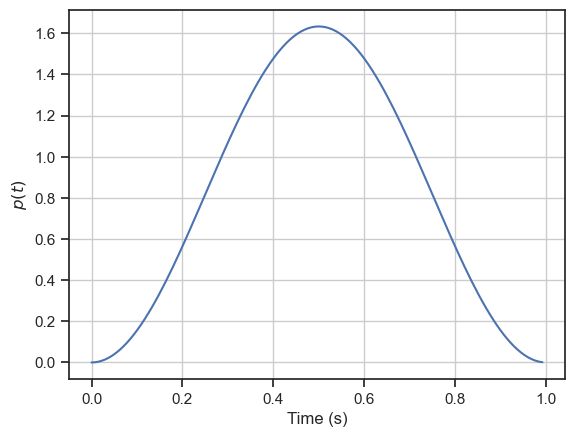

In [4]:
## plot the pulse shape
tt = np.arange(fsT)/fs
plt.plot(tt, pp)
plt.grid()

plt.xlabel('Time (s)')
plt.ylabel('$p(t)$')

plt.show()

### Synthesize transmitted signal

The transmitted signal can now be synthesized using the functions (from the `comms` package)
* `string_source` - to produce a sequence of bits
* `mod_mapper` - to turn bits into symbols
* `pulse_shape` - to perform pulse shaping

In [5]:
# make a signal
bits = string_source('Hi')
syms = mod_mapper(bits, PAM4)
sig = pulse_shape(syms, pp, fsT)

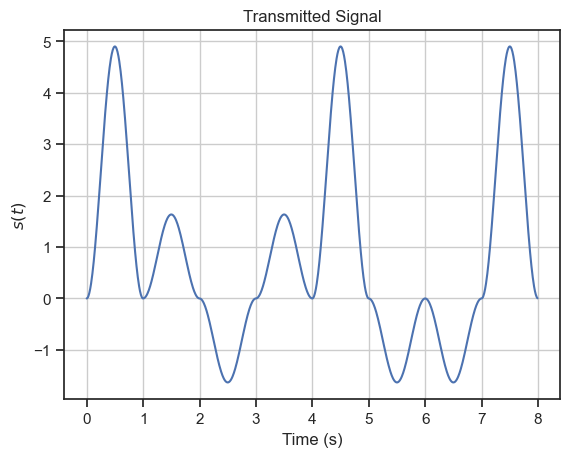

In [6]:
# plot the transmitted signal
tt = np.arange(len(sig))/fs

plt.plot(tt, sig.real)
plt.grid()

plt.xlabel('Time (s)')
plt.ylabel('$s(t)$')

plt.title('Transmitted Signal')

plt.show()

### Channel

* During propagation from the transmitter to the receiver, the transmitted signal is corrupted by noise.
  - this is simulated by adding Gaussian pseudo-random numbers to the transmitted signal (using `np.random.randn`)
* The received signal is a noisy version of the transmitted signal.

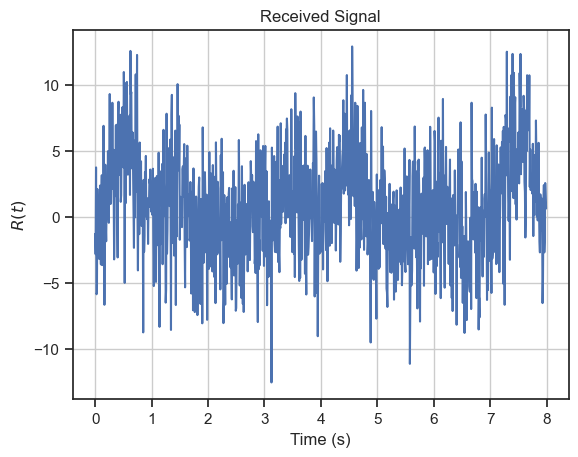

In [7]:
## simulate channel - additive noise
n_pwr = fsT/10  # 10dB SNR
r_sig = sig.real + np.sqrt(n_pwr) * np.random.randn(len(sig))

## plot the received signal
tt = np.arange(len(r_sig))/fs

plt.plot(tt, r_sig)
plt.grid()

plt.xlabel('Time (s)')
plt.ylabel('$R(t)$')

plt.title('Received Signal')

plt.show()

### Receiver

* The first processing step in the receiver is the matched filter.
  - the impulse response of the matched filter is $h_{MF}(t) = p(T - t$)$
    + the delay $T$ ensures a causal filter as the length of $p(t$)$ is $T$.
  - For a symmetric pulse, the matched filter impulse response has the same shape as the pulse  

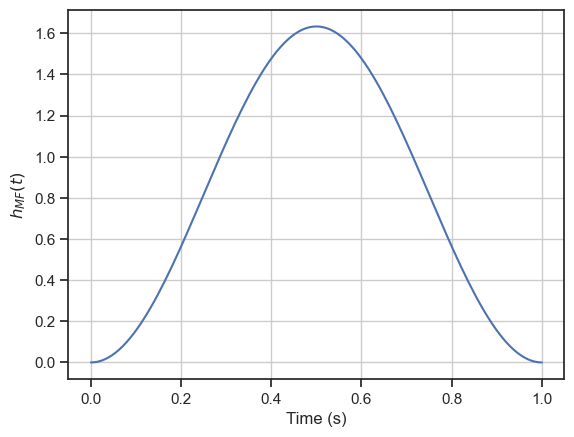

In [8]:
## construct the matched filter
h_MF = np.zeros(len(pp) + 1)
h_MF[np.arange(len(pp), 0, -1)] = pp

## plot it
plt.plot(np.arange(len(h_MF))/fs, h_MF)
plt.grid()

plt.xlabel('Time (s)')
plt.ylabel('$h_{MF}(t)$')

plt.show()

#### Pass received signal through the matched filter

* The output signal $y(t)$ from the matched filter is obtained by convolving the received signal $R(t)$ and the impulse response $h_{MF}(t)$.
  - to approximate the continuous-time convolutiopn, we must divide the result of the discrete-time convolution (`np.convolve()`) by $f_s$.
* The output from the matched filter is **much** less noisy 
  - the matched filter passes the signal but rejects most of the noise

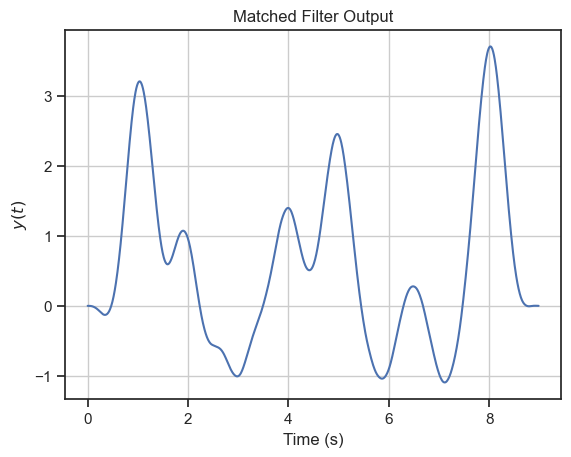

In [9]:
## compute the matched filter output
# since the transmitted signal is real, we're only interested in teh real part
mf_out = np.real( np.convolve(r_sig, pp)/fs )

## plot the matched filter output
tt = np.arange(len(mf_out))/fs

plt.plot(tt, mf_out)
#plt.plot(np.arange(len(syms))+1, syms, 'o')
#plt.plot(np.arange(len(syms))+1, mf_out[fsT-1::fsT], 'gx')
plt.grid()

plt.xlabel('Time (s)')
plt.ylabel('$y(t)$')
plt.title('Matched Filter Output')

plt.show()

#### Sampling

* The final step in the receiver is sampling the matched filter outputs.
  + Recall that the matched filter was delayed by one symbol period $T$ to make it causal
  + Hence:
    - the estimate for symbol $s_0$ is found by sampling at time T, i.e., $\hat{s}_0 = y(T)$
    - the estimate for symbol $s_1$ is found by sampling at time 2T, i.e., $\hat{s}_1 = y(2T)$
    - the estimate for symbol $s_n$ is found by sampling at time (n+1)T, i.e., $\hat{s}_n = y((n+1)T)$

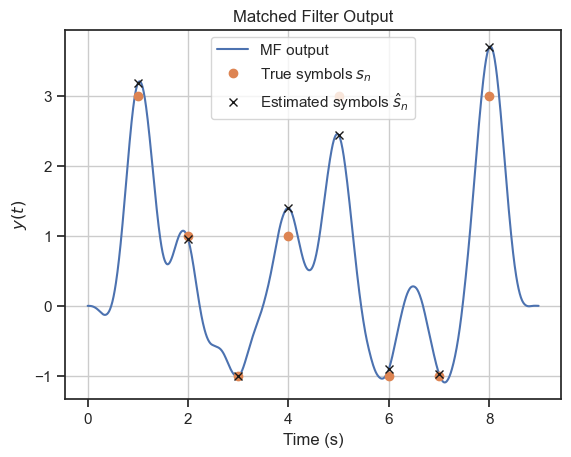

In [10]:
## plot the matched filter output and mark the symbol estimates
tt = np.arange(len(mf_out))/fs

plt.plot(tt, mf_out, label='MF output')
plt.plot(np.arange(len(syms))+1, np.real(syms), 'o', label='True symbols $s_n$')
plt.plot(np.arange(len(syms))+1, mf_out[fsT::fsT], 'kx', label='Estimated symbols $\hat{s}_n$')
plt.grid()

plt.xlabel('Time (s)')
plt.ylabel('$y(t)$')
plt.title('Matched Filter Output')

plt.legend()

plt.show()

In [11]:
## let's see what was received
rx_syms = mf_out[fsT::fsT]
rx_bits = demodulator(rx_syms, mod_table)

print('Received message:', string_sink(rx_bits))

Received message: Hi


## A longer signal

* We repeat the experiment above with a longer signal
  - using a longer string
  - the remainder is exactly the same as above

In [12]:
# make a signal
bits = string_source('Now is the time for all good men ...')
syms = mod_mapper(bits, PAM4)
sig = pulse_shape(syms, pp, fsT)

# channel
n_pwr = fsT/10  # 10dB SNR
r_sig = sig.real + np.sqrt(n_pwr) * np.random.randn(len(sig))

# receiver
mf_out = np.real( np.convolve(r_sig, pp)/fs )
rx_syms = mf_out[fsT::fsT]
rx_bits = demodulator(rx_syms, mod_table)

print('Received message:', string_sink(rx_bits))

Received message: Now is the time for all good men ...


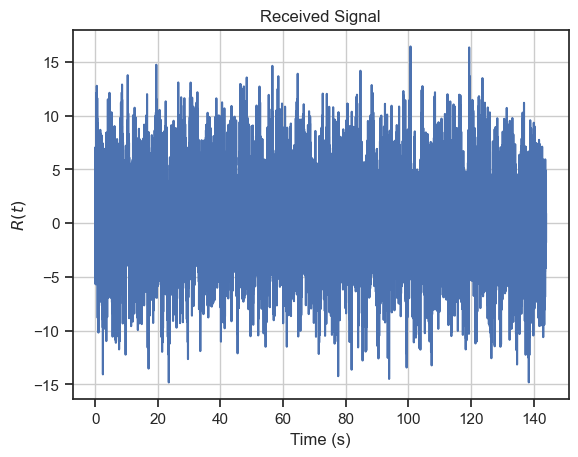

In [13]:
## plot the received signal
tt = np.arange(len(r_sig))/fs

plt.plot(tt, r_sig)
plt.grid()

plt.xlabel('Time (s)')
plt.ylabel('$R(t)$')

plt.title('Received Signal')

plt.show()

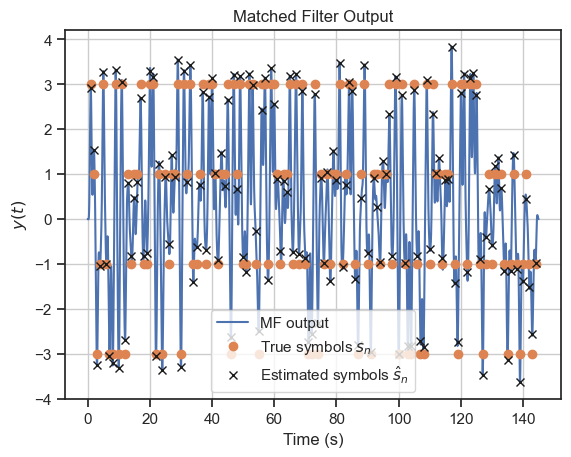

In [14]:
## plot the matched filter output and mark the symbol estimates
tt = np.arange(len(mf_out))/fs

plt.plot(tt, mf_out, label='MF output')
plt.plot(np.arange(len(syms))+1, np.real(syms), 'o', label='True symbols $s_n$')
plt.plot(np.arange(len(syms))+1, rx_syms, 'kx', label='Estimated symbols $\hat{s}_n$')
plt.grid()

plt.xlabel('Time (s)')
plt.ylabel('$y(t)$')
plt.title('Matched Filter Output')

plt.legend()

plt.show()

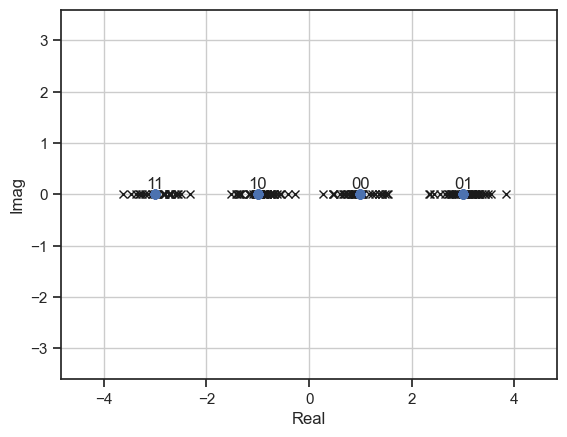

In [15]:
## scatter plot the received symbols
plot_constellation(mod_table)

plt.plot(np.real(rx_syms), np.imag(rx_syms), 'kx')
plt.plot(np.real(syms), np.imag(syms), 'bo')

plt.show()

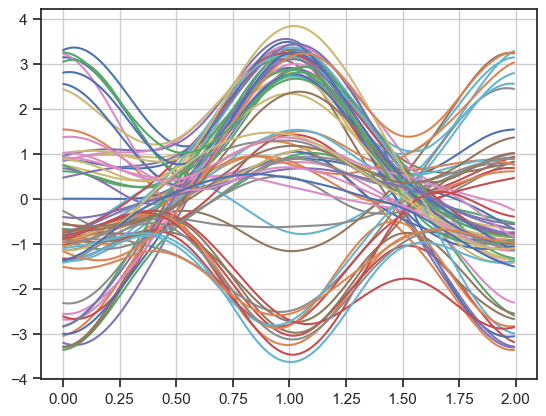

In [16]:
## Eye diagram
# plot consecutive 2T matched filter outputs on top of each other
tt = np.arange(2*fsT)/fs
for n in np.arange(len(syms)//2):
    plt.plot(tt, mf_out[2*n*fsT : 2*(n+1)*fsT])

plt.grid()